<a href="https://colab.research.google.com/github/isitoptopi/Ml-project/blob/main/projjml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,accuracy_score,balanced_accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score,multilabel_confusion_matrix,confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import nltk
import re
import itertools
import string
import collections
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('/content/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
def get_types(row):
    t = row['type']

    I = 0; N = 0
    T = 0; J = 0

    if t[0] == 'I': I = 1
    elif t[0] == 'E': E = 0
    else: print('I-E not found')

    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')

    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')

    return pd.Series({'IE': I, 'NS': N, 'TF': T, 'JP': J})

data = data.join(data.apply(lambda row: get_types(row), axis=1))
data.head(5)


,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [4]:
print("Introversion (I) / Extroversion (E):\t", data['IE'].value_counts()[1], " / ", data['IE'].value_counts()[0])
print("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[1], " / ", data['NS'].value_counts()[0])
print("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[1], " / ", data['TF'].value_counts()[0])
print("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[1], " / ", data['JP'].value_counts()[0])


Introversion (I) / Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 3981  /  4694
Judging (J) / Perceiving (P):		 3434  /  5241


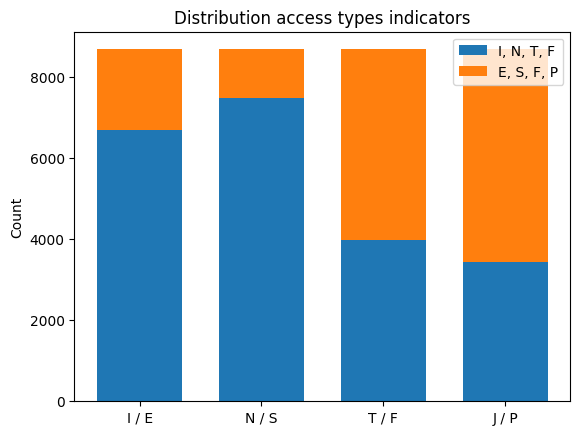

In [5]:
N = 4
bottom = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])
top = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])

ind = np.arange(N)    # the x locations for the groups
width = 0.7           # the width of the bars

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P")

plt.title('Distribution access types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E', 'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()


In [6]:
data[['IE', 'NS', 'TF', 'JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,-0.069573,0.161939
NS,-0.045899,1.000000,-0.080954,0.014922
TF,-0.069573,-0.080954,1.000000,-0.004673
JP,0.161939,0.014922,-0.004673,1.000000


In [7]:
cmap = plt.cm.RdBu

<Axes: title={'center': 'features correlation heatmap'}>

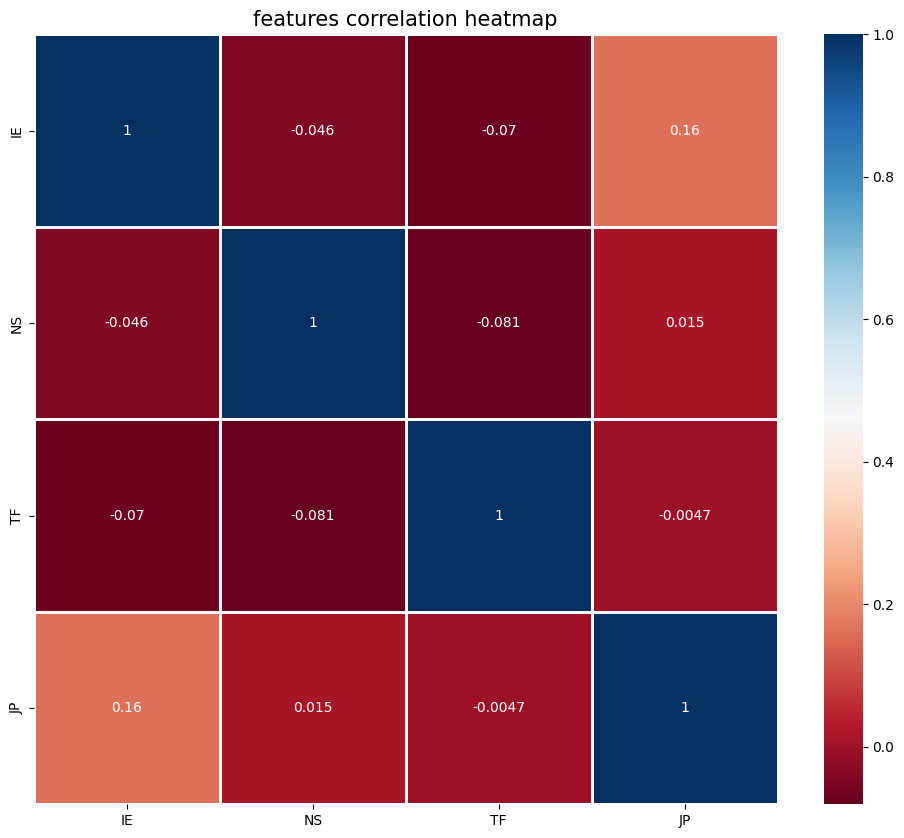

In [8]:
corr = data [['IE', 'NS', 'TF', 'JP']].corr()
plt.figure(figsize=(12,10))
plt.title('features correlation heatmap',size=15)
sns.heatmap(corr,cmap=cmap, annot=True,linewidths=1)

In [9]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
                    'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESFP', 'ESTP', 'ESFJ', 'ESTJ']
unique_type_list = [x.lower() for x in unique_type_list]


In [10]:
b_Pers = {'I': 0, 'E': 1, 'N': 0, 'S': 1, 'F': 0, 'T': 1, 'J': 0, 'P': 1}
b_Pers_list = [{0: 'I', 1: 'E'}, {0: 'N', 1: 'S'}, {0: 'F', 1: 'T'}, {0: 'J', 1: 'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # Transform binary vector to MBTI personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list:\n%s" % list_personality_bin)

Binarize MBTI list:
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [11]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []

  len_data = len(data)

  for row in data.iterrows():

    # # check code working
    # if 1001 == 1:
    #   print(oforos(1, len_data))

    # remove emojis and clean comments
    posts = row[1].posts

    temp = re.sub(r"https://([a-zA-Z0-9_.+-]){1,20}\w+(:[0-9]+)?(/[^s]*)?", "", posts)
    temp = re.sub(r"[^\w\s]", "", temp)

    # remove spaces
    temp = re.sub(r"\s+", " ", temp).lower()

    # remove multiple letter repeating words
    temp = re.sub(r"(.)\1{2,}", r"\1\1", temp)

    # remove stop words
    if remove_stop_words:
      temp = " ".join([lemmatiser.lemmatize(word) for word in temp.split() if word not in useless_words])
    else:
      temp = " ".join([lemmatiser.lemmatize(word) for word in temp.split()])

    # remove MBTI personality type words
    if remove_mbti_profiles:
      for t in unique_type_list:
        temp = temp.replace(t, "")

    # transform MBTI to binary vector
    type_labeled = translate_personality(row[1].type)  # or use an encoder.transform(row[1].type)[]

    list_personality.append(type_labeled)

    # the cleaned text temp is appended here
    list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)

  return list_posts, list_personality

list_posts, list_personality = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example:")
print("\npost vefore preprocessign:\n\n", data.posts[0])

Example:

post vefore preprocessign:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/upl

In [12]:
cntizer = CountVectorizer(analyzer='word',
                          max_features=1000,
                          max_df=0.7,
                          min_df=0.1)

# The feature should be made of word n-gram
# Learn the vocabulary dictionary and return term-document matrix

print("Using CountVectorizer:")
X_cnt = cntizer.fit_transform(list_posts)

# The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))

print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage -
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing T-Lof")

print("How the dataset size is as below")
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

print(X_tfidf.shape)

Using CountVectorizer:
10 feature names can be seen below
[(0, '10'), (1, '100'), (2, '20'), (3, 'ability'), (4, 'able'), (5, 'absolutely'), (6, 'accept'), (7, 'accurate'), (8, 'across'), (9, 'act')]

Using T-Lof
How the dataset size is as below
(8675, 761)


In [13]:
personality_type = ["IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving 1  (P)"]

for i in range(len(personality_type)):
    print(personality_type[i])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving 1  (P)


In [14]:
print("X: 1st posts in tf-idf representation \n%s" %X_tfidf[0])

X: 1st posts in tf-idf representation 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08589704 0.07184541
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.10891149
 0.         0.         0.05238584 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.11075428
 0.         0.         0.         0.         0.         0.05512562
 0.07206961 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

In [15]:
print("for MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : binarized MBTI 1st row : %s" % list_personality[0,:])

for MBTI personality type : INFJ
Y : binarized MBTI 1st row : [0 0 0 0]


In [16]:
X=X_tfidf

In [17]:
for i in range(len(personality_type)):
    y = list_personality[:, i]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

    # Fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[i], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.98%
NS: Intuition (N) / Sensing (S) Accuracy: 85.75%
FT: Feeling (F) / Thinking (T) Accuracy: 71.88%
JP: Judging (J) / Perceiving 1  (P) Accuracy: 62.31%


In [18]:
param={}
param['n_extimaors']=200
param['max_depth']=2
param['nthread']=8
param['learning_rate']=0.2

#individually training each mbti personality type

for i in range(len(personality_type)):
    y = list_personality[:, i]

    #split data into train and test sets
    seed=7
    test_size=0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    #fit model training on data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    #make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    #evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("%s Accuracy: %.2f%%" % (personality_type[i], accuracy * 100.0))
    my_posts="""Doing stupid or clumsy things because you forgot to pay attention to the real
      world again, walked into doors, burned your food, maybe jumped a redight
      When someone is Having Feelings in your vicinity, you are having those eelings right along
      with them, even if you don't know who they are or why hey're upset
      ART VS, SCIENCE
      Really wanting to have your life all organised and together but also being he sort of person
      who just doesn't do that
      When you look at a thing and it reminds you of another thing but nobody else sees it and then
      you become the weird one -Dropping everything you're doing to google something you got curious about, or draw an
      image that just occurred to you, or in any way indulging a sudden burst of imagination before
      it slips away and your boring life returns -Having to say I DON'T KNOW HOW TO EXPLAIN IT IT'S JUST THIS
      FEELING on a daily basis to a bunch of blank faces
      Nobody seems to appreciate the value of a long walk by yourself
      The sensible, logical voice in your head is constantly facepalming at all the stupid stuff you
      do, even though it told you this was a bad idea
      Your best solution to most potential problems is 'T'll just take to the woods and live alone
      with the trees where nobody will care what I do'
      What are you staring at? What are you smiling about? Why the sudden. When you're focused on something important then you start thinking all hese other thoughts
      about the thing and then it snowballs and you realise you have no idea what you started off
      focused on anymore
      The inside of your head is basically Jean Valjean's " oop Who Am I?' playing on"""

    #the type is just dummy
    mydata=pd.DataFrame(data={'type':['INFJ'],'posts':[my_posts]})

    my_posts,dummy = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

    my_X_cnt = cntizer.transform(my_posts)
    my_X_tfidf = tfizer.transform(my_X_cnt).toarray()
    param
    my_y_pred = model.predict(my_X_tfidf)
    param={}
    param['n_extimaors']=200
    param['max_depth']=2
    param['nthread']=8
    param['learning_rate']=0.2

    result =[]
    for i in range(len(personality_type)):
      print(personality_type[i])
      y = list_personality[:, i]

      x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=7)

      model = XGBClassifier(**param)
      model.fit(x_train, y_train)

      y_pred = model.predict(my_X_tfidf)
      result.append(y_pred[0])



d = {
    "INTJ": "MASTERMIND",
    "INTP": "ARCHITECT",
    "ENTJ": "FIELDMARSHAL",
    "ENTP": "INVENTOR",
    "INFJ": "COUNSELOR",
    "INFP": "HEALER",
    "ENFJ": "TEACHER",
    "ENFP": "CHAMPION",
    "ISTJ": "INSPECTOR",
    "ISFJ": "LOGISTICIAN",
    "ESTJ": "EXECUTIVE",
    "ESFJ": "CONSUL",
    "ESTP": "ENTREPRENEUR",
    "ESFP": "PERFORMER",
    "ISTP": "VIRTUOSO",
    "ISFP": "ADVENTURER"
}

print(translate_back(result), d[translate_back(result).split()[0]], sep=":")

IE: Introversion (I) / Extroversion (E) Accuracy: 78.20%
IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving 1  (P)
NS: Intuition (N) / Sensing (S) Accuracy: 85.99%
IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving 1  (P)
FT: Feeling (F) / Thinking (T) Accuracy: 72.20%
IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving 1  (P)
JP: Judging (J) / Perceiving 1  (P) Accuracy: 64.90%
IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving 1  (P)
INTP:ARCHITECT
